<a href="https://colab.research.google.com/github/pranshurastogi29/clustering-the-palsy/blob/master/enhanced_fcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = 10 * np.min(deltas)/np.max(big_deltas)
    return di

In [0]:
df=pd.read_csv('/content/drive/My Drive/norm.csv')

In [0]:
df_req = df[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)','classs']]
X  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']]
labels = df.classs

In [0]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist

class FCM:
    """Fuzzy C-means
    
    m: float, optional (default=2.0)
        Exponent for the fuzzy partition matrix, specified as a
        scalar greater than 1.0. This option controls the amount of
        fuzzy overlap between clusters, with larger values indicating
        a greater degree of overlap.
    
    u: array, shape = [n_samples, n_clusters]
        Fuzzy partition array, returned as an array with n_samples rows
        and n_clusters columns. Element u[i,j] indicates the degree of
        membership of the jth data point in the ith cluster. For a given
        data point, the sum of the membership values for all clusters is one.
    
    """
    def __init__(self, n_clusters=10, max_iter=150, m=2, error=1e-5, random_state=42):
        assert m > 1
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state

    def fit(self, X):
        
        self.n_samples = X.shape[0]
        r = np.random.RandomState(self.random_state)
        u = r.rand(self.n_samples, self.n_clusters)
        u = u / np.tile(u.sum(axis=1)[np.newaxis].T, self.n_clusters)

        r = np.random.RandomState(self.random_state)
        self.u = r.rand(self.n_samples,self.n_clusters)
        self.u = self.u / np.tile(self.u.sum(axis=1)[np.newaxis].T, self.n_clusters)

        for iteration in range(self.max_iter):
            u_old = self.u.copy()

            self.centers = self.next_centers(X)
            self.u = self._predict(X)

            if norm(self.u - u_old) < self.error:
                break


    def next_centers(self, X):
        
        um = self.u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).T

    def _predict(self, X):
        
        power = float(2 / (self.m - 1))
        temp = cdist(X, self.centers) ** power
        val = (1-self.u)@(temp.T**2)
        memship_function = (1/(temp**2+1))
        memship_function = val @ memship_function

        if temp.shape[0] == memship_function.shape[0]:
          temp = temp**2 + memship_function
          denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
          denominator_ = temp[:, :, np.newaxis] / denominator_
          return 1 / denominator_.sum(2)

        if temp.shape[0] < memship_function.shape[0]:
          temp = temp**2 + memship_function[:temp.shape[0]]
          denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
          denominator_ = temp[:, :, np.newaxis] / denominator_
          return 1 / denominator_.sum(2)

    def predict(self, X):

        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)

        u = self._predict(X)
        return np.argmax(u, axis=-1)

In [0]:
a = FCM(n_clusters = 2)

In [0]:
b = a.fit(X.values)

In [0]:
c = a.predict(X.values)

In [0]:
dunn(a.centers)

0.003873668901273179

In [0]:
a.centers

array([[  0.87541337, 108.83957678,   0.68560263,  10.55439302],
       [  0.81594256, 154.06393133,   0.53814115,   6.10077745]])

In [0]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X.values,c, metric='euclidean'))

Silhouette Coefficient: 0.470


In [0]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [0]:
from sklearn.model_selection import StratifiedKFold
from scipy import stats
kfold = StratifiedKFold(n_splits=16, random_state = 42)
cpi = []
preds = []
X1 = X.values
for train_index, test_index in kfold.split(X1,labels):
  X_train, X_test = X1[train_index], X1[test_index]
  y_train, y_test = labels[train_index], labels[test_index]
  a = FCM(n_clusters = 2)
  b = a.fit(X_train)
  d = int(len(X1)/len(X_train))
  c=[]
  pure = 0
  for i in range(0,d+1):
    v = X1[i*len(X_train):(i+1)*len(X_train)]
    m = a.predict(v)
    z = purity_score(labels[i*len(X_train):(i+1)*len(X_train)],m)
    c = [*c,*m]
    pure = pure + z*len(v)/len(X1)
  print('pure',pure)
  print('<<---->>')
  cpi.append(pure)
  preds.append(c)
preds = np.array(preds)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



pure 0.6282051282051282
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.6346153846153846
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.6346153846153846
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.641025641025641
<<---->>
pure 0.6282051282051282
<<---->>
pure 0.6217948717948718
<<---->>
pure 0.6217948717948718
<<---->>
pure 0.6217948717948718
<<---->>
pure 0.6217948717948718
<<---->>


In [0]:
from sklearn.metrics.pairwise import euclidean_distances
x = X.values
def get_cls(c,x):
  cl0,cl1 = [],[]
  for i in range(len(c)):
    if c[i] == 0:
      cl0.append(x[i])
    if c[i] == 1:
      cl1.append(x[i])
  return cl0,cl1
cl0,cl1 = get_cls(preds[np.argmax(cpi)],x)
def cluster_dist(cl0,cl1):
  d0 = cdist(cl0, cl1)
  d1 = cdist(cl1, cl0)
  A = cdist(cl0, cl0)
  C = cdist(cl1, cl1)
  d0 = np.sum(np.mean(d0,axis=1),axis=0)
  d1 = np.sum(np.mean(d1,axis=1),axis=0)
  a = np.sum(np.sum(A,axis=1)/len(A))/2
  c = np.sum(np.sum(C,axis=1)/len(C))/2
  return min([d0,d1]),(a+c)/2
inter_cluster,intra_cluster = cluster_dist(cl0,cl1)
print('inter_cluster_distance =',inter_cluster,
    "The average intra_cluster is :", intra_cluster)

inter_cluster_distance = 2597.717149654017 The average intra_cluster is : 826.0205429504484


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.46998039685173904
For n_clusters = 3 The average silhouette_score is : 0.5334388815969267
For n_clusters = 4 The average silhouette_score is : 0.45783540281732865
For n_clusters = 5 The average silhouette_score is : 0.36686946611063576
For n_clusters = 6 The average silhouette_score is : 0.4212440966907528
For n_clusters = 7 The average silhouette_score is : 0.39509005829219784


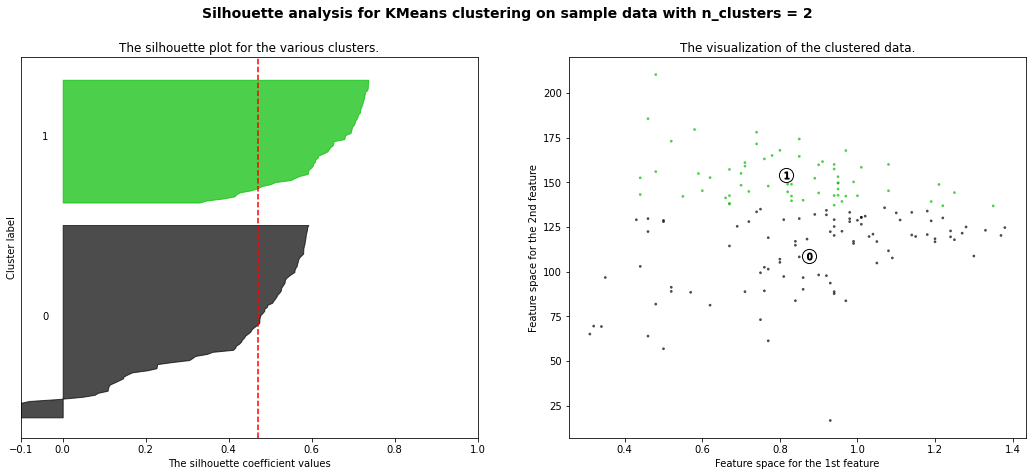

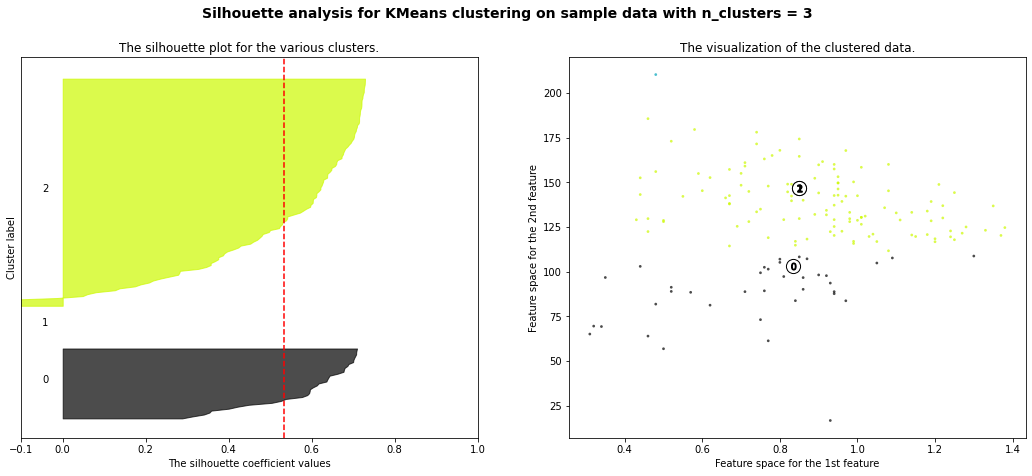

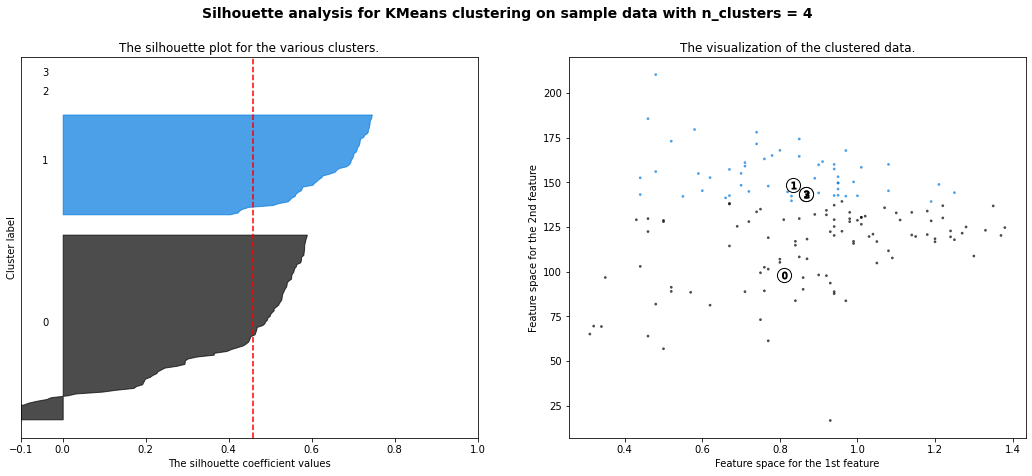

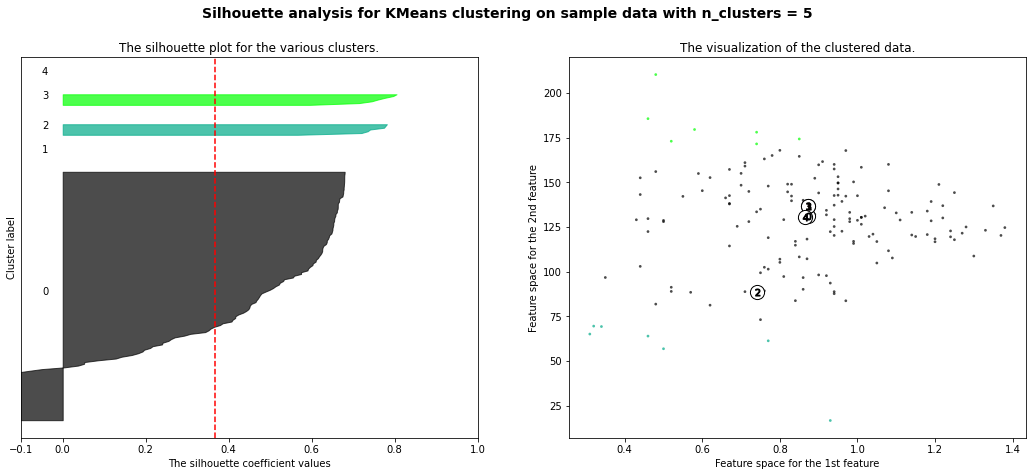

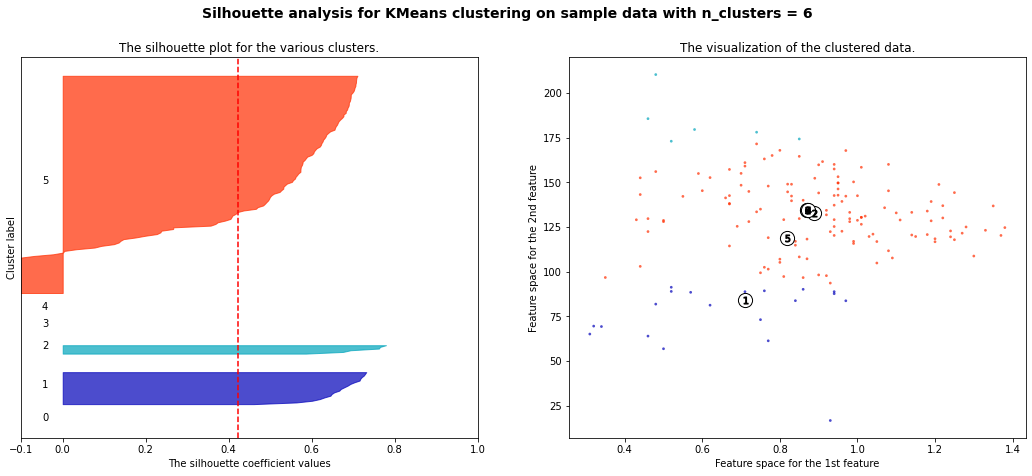

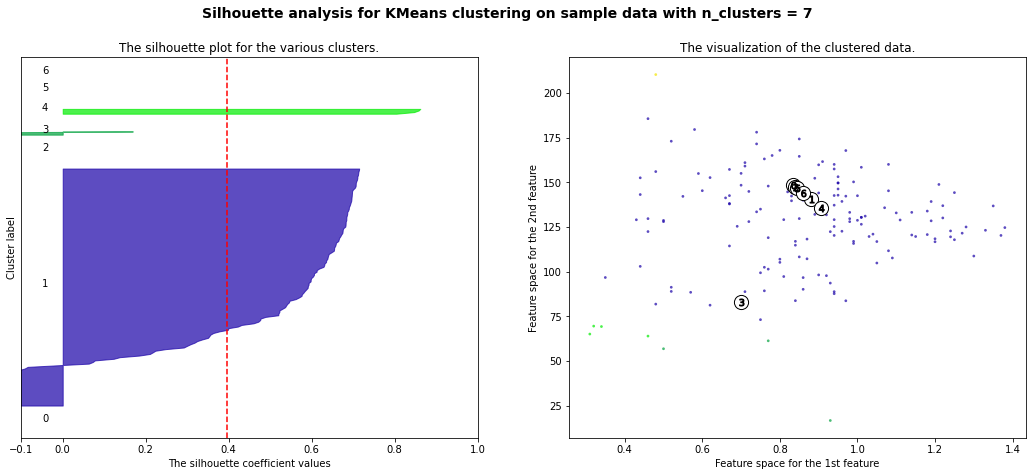

In [0]:
import matplotlib.cm as cm

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
silhouette= []
range_n_clusters = [2, 3, 4, 5, 6,7]
X  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']].values
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = FCM(n_clusters=n_clusters)
    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.centers
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [0]:
import plotly.graph_objects as go

x = range_n_clusters

fig = go.Figure(data=go.Scatter(x=x, y=silhouette))
fig.show()